# Post 3: Semi-Supervised Anomaly Detection

In this Post, I will focus on using semi-supervised machine learning technique for anomaly detection. This post covers M6 Special Topic: Semi-Supervised Techniques.

I will not be spending too much time on details of the semi-supervised technique as it is a wide area and beyond the scope of the post. I will instead focus on the application side of the technique. For a detailed analysis please refer to the book.

Although the anomaly detection technique is shown for this dataset only, there are many situations where we can apply the same technique.

Although this code is in Python, I made an R version of the code.

I studied the material and found several python codes that are incorporated here. Another R-Implementation is attached. As the size of the data is quite large, it takes a while to run the experiments. 

## Dataset
I collected the dataset from Kaggle (https://www.kaggle.com/mlg-ulb/creditcardfraud). There are many kernerls there working on the dataset. I have collected many of the code snippets from their kernels that helped me understanding the concept. Please feel free to take a look into the kernels from Kaggle users.

This dataset presents two days of transactions, with 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, fraud is detected only for 0.172% of all transactions.

## Anomaly Definition
Anomaly is something that we get from some process other than the underlying one. As per wikipedia, it is the identification of rare items,, events or observations which raise suspicions by differing significantly from the majority of the data. Anomaly is present in almost every datasets, for example, in bank fraud, structural defect, medical problems, or texual errors. Sometimes it is also called outliers, deviations, exceptions.


## Challenges

Typical straightforward approach might not work for anomaly detection.

 - We might be tempted to consider anomaly detection as a binary classification problem where one set of data is normal and another set of data is abnormal. However, as very little, typically less than 1% of the data may be abnormal, therefore, a classic binary classifier may not work well.
 - Anomalies are typically a malicious data, which is generated by adversaries. Therefore, those data are created to make it look normal and making it very hard to detect.
 - Labeled data for anomally detection is typically not available and hard to get.
 - Different systems describes normal behavior differently. Therefore the definition varies system to system and one size does not fit all.

### We begin by reading loading some packages required

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt, style
import seaborn as sns
from sklearn.metrics import fbeta_score, precision_score, recall_score, confusion_matrix # for evaluation
import itertools

style.use('ggplot')
np.random.seed(1)

### Reading Dataset

The distribution of Amount and Time are found to be log normal. As the analytical part works better if we take the data as normal, we will transform the Amount and Time to log. To avoid zeroes, we add 1 before log

In [2]:
dataset = pd.read_csv('data/creditcard.csv')

dataset['Amount'] = np.log(dataset['Amount'] + 1)
dataset['Time'] = np.log(dataset['Time'] + 1)

normal = dataset[dataset['Class'] == 0]
anomaly = dataset[dataset['Class'] == 1]

print(normal.shape)
print(anomaly.shape)

(284315, 31)
(492, 31)


Next we split the data into train, test, and validation sets. We use the following:

* 80% of the normal instances are used for training. The remaining 20% are for validation and test
* Of the remaining 20%, we choose 50% for validation and the remaining for testing

In [3]:
from sklearn.model_selection import train_test_split

train, normal_test, _, _ = train_test_split(normal, normal, test_size=.2, random_state=1)
normal_valid, normal_test, _, _ = train_test_split(normal_test, normal_test, test_size=.5, random_state=1)
anormal_valid, anormal_test, _, _ = train_test_split(anomaly, anomaly, test_size=.5, random_state=1)

train = train.reset_index(drop=True)
valid = normal_valid.append(anormal_valid).sample(frac=1).reset_index(drop=True)
test = normal_test.append(anormal_test).sample(frac=1).reset_index(drop=True)

print("Normal shape:", normal.shape)
print('Train shape: ', train.shape)
print('Proportion os anomaly in training set: %.2f\n' % train['Class'].mean())
print('Valid shape: ', valid.shape)
print('Proportion os anomaly in validation set: %.2f\n' % valid['Class'].mean())
print('Test shape:, ', test.shape)
print('Proportion os anomaly in test set: %.2f\n' % test['Class'].mean())

Normal shape: (284315, 31)
Train shape:  (227452, 31)
Proportion os anomaly in training set: 0.00

Valid shape:  (28677, 31)
Proportion os anomaly in validation set: 0.01

Test shape:,  (28678, 31)
Proportion os anomaly in test set: 0.01



Note that training consists only of normal data. The expectation is that as the training data is behaving as normal, and outsider data that is feed into it should exhibit some large error marging. Therefore, we expect to detect fradus in the validation sets.

## Evaluation Metrics
As noted before, as the data is highly skewed, we will not use accuracy as the evaluation. We will instead be using Precision and Recall.

### Preceision
Precision $P$ is defined as the number of true positives $T_p$ over the number of true positives plus the number of false positives $F_p$:

$$P = \frac{T_p}{T_p + F_p}$$

### Recall
Recall $R$ is defined as the number of true positives $T_p$ over the number of true positives plus the number of false negatives $F_n$:

$$R = \frac{T_p}{T_p + F_n}$$

### $F_2$ Score
To summarize the model's performance in a single metric, we will use the $F_2$ score, which places more importance in recall than precision. Formally, it is defined as

$$F_2 = (1+2^2) \frac{P * R}{2^2 * P + R}$$

We will also report confusion matrix for a better understanding of how our errors are distributed.


The following code prints a confusion matrix.

In [4]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.show()

# Method 1: Statistical Anomaly Detection Techniques: Gaussian Model

Here, we assume that the data are coming for a Gaussian distribution. Therefore, we fit a Gaussian MLE (Maximum Likelihood Estimates). Our model takes two parameter, mu and sigma. We build the model using multivariate_normal model.

In [5]:
from scipy.stats import multivariate_normal

mu = train.drop('Class', axis=1).mean(axis=0).values

sigma = train.drop('Class', axis=1).cov().values

#Gaussian Model
model = multivariate_normal(cov=sigma, mean=mu, allow_singular=True)

print(np.median(model.logpdf(valid[valid['Class'] == 0].drop('Class', axis=1).values))) 
print(np.median(model.logpdf(valid[valid['Class'] == 1].drop('Class', axis=1).values))) 

-32.78419912610982
-827.48353573235


After modeling with the mean from train, we run the model on validation set. As seen from the above, the median of lognormal model for normal is quite different from the median of anomal data. Next we evaludate the data based on classifying the data as Anomal by some different threshold.

In [6]:
tresholds = np.linspace(-1000,-10, 150)
scores = []
for treshold in tresholds:
    y_hat = (model.logpdf(valid.drop('Class', axis=1).values) < treshold).astype(int)
    scores.append([recall_score(y_pred=y_hat, y_true=valid['Class'].values),
                 precision_score(y_pred=y_hat, y_true=valid['Class'].values),
                 fbeta_score(y_pred=y_hat, y_true=valid['Class'].values, beta=2)])

scores = np.array(scores)
print(scores[:, 2].max(), scores[:, 2].argmax())

0.7658022690437601 103


We now plot the Precision, Recall and $F_2$-score as a function of this threshold.

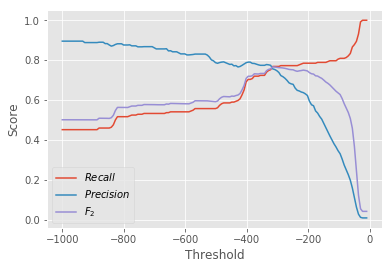

In [7]:
plt.plot(tresholds, scores[:, 0], label='$Recall$')
plt.plot(tresholds, scores[:, 1], label='$Precision$')
plt.plot(tresholds, scores[:, 2], label='$F_2$')
plt.ylabel('Score')
plt.xlabel('Threshold')
plt.legend(loc='best')
plt.show()

Finally, we report the test recall, precision and $F_2$-score, along with the confusion matrix.

Final threshold: -315
Test Recall Score: 0.764
Test Precision Score: 0.707
Test F2 Score: 0.752


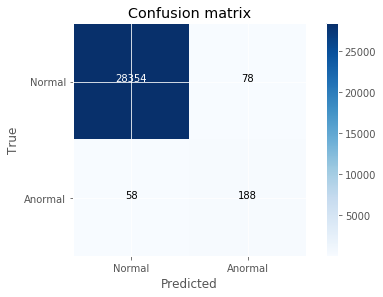

In [8]:
final_tresh = tresholds[scores[:, 2].argmax()]
y_hat_test = (model.logpdf(test.drop('Class', axis=1).values) < final_tresh).astype(int)

print('Final threshold: %d' % final_tresh)
print('Test Recall Score: %.3f' % recall_score(y_pred=y_hat_test, y_true=test['Class'].values))
print('Test Precision Score: %.3f' % precision_score(y_pred=y_hat_test, y_true=test['Class'].values))
print('Test F2 Score: %.3f' % fbeta_score(y_pred=y_hat_test, y_true=test['Class'].values, beta=2))

cnf_matrix = confusion_matrix(test['Class'].values, y_hat_test)
plot_confusion_matrix(cnf_matrix, classes=['Normal','Anormal'], title='Confusion matrix')

* We get an $F_2$ score of 0.76 which is not too bad. 58 of the anormal data is detected as normal.
* The method is very fast.
* However, the true distribution of the data may not be Gaussian.

Next, we explore another statistical technique based on histogram.

# Method 2: Statistical Anomaly Detection Techniques: Histogram Based Method

The model seen above is a parametric one in the sense the we only estimate the parameters of the multivariate distribution, namely the mean and covariance matrix. Another option is to use a non-parametric statistical technique. Here, we consider using histograms to model the normal data profile. Bellow, we see 5 histograms for different features in our data, both for normal and anomalous instances. 

/Users/fda/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


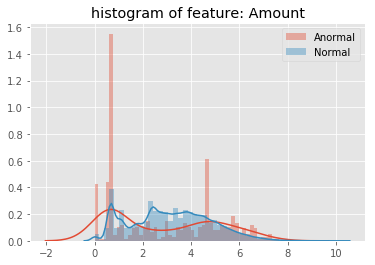

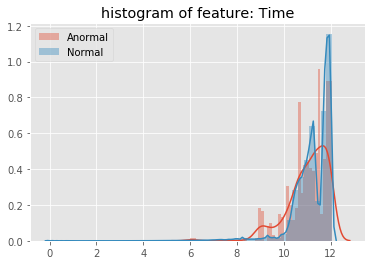

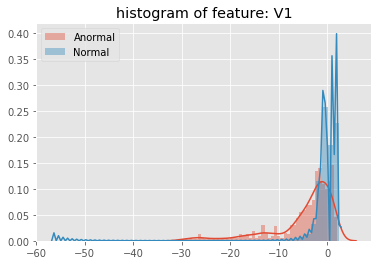

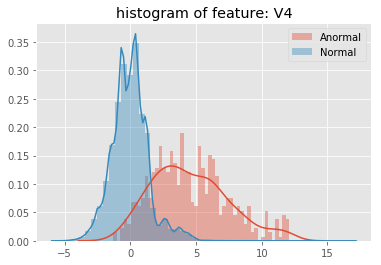

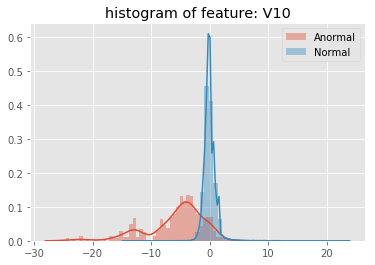

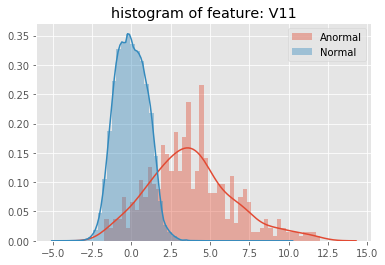

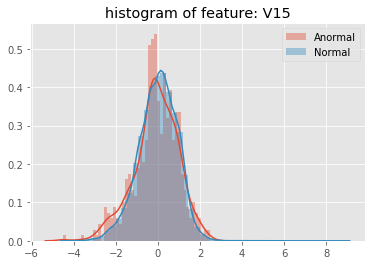

In [9]:
import matplotlib.gridspec as gridspec

for feature in ['Amount', 'Time', 'V1', 'V4', 'V10', 'V11', 'V15']:
    ax = plt.subplot()
    sns.distplot(dataset[feature][dataset.Class == 1], bins=50, label='Anormal')
    sns.distplot(dataset[feature][dataset.Class == 0], bins=50, label='Normal')
    ax.set_xlabel('')
    ax.set_title('histogram of feature: ' + str(feature))
    plt.legend(loc='best')
    plt.show()

Let us assume that the histogram approximate the true distribution of data. Note that previously we assumed all are Gaussian. But taking a look into the data we see that some of the data are not Gaussian. For example, Amount is not Gaussian. 

Note that the distribution for Fradulant and Normal differs quite a bit in the above figures. Therefore, we can exploit those features to create a model to classify. First we make histogram from the training data. Then at the evaluation time, we determine the count of histogram data from the evaluation features. Those with the anomaly are expected to be quite different. We then flag it as an anomaly.

In [10]:
class hist_model(object):
    
    def __init__(self, bins=50):
        self.bins = bins
        
    def fit(self, X):
        bin_hight, bin_edge = [], []
        for var in X.T:
            bh, bedge = np.histogram(var, bins=self.bins)
            bin_hight.append(bh)
            bin_edge.append(bedge)
        
        self.bin_hight = np.array(bin_hight)
        self.bin_edge = np.array(bin_edge)
   
    def predict(self, X):
        scores = []
        for obs in X:
            obs_score = []
            for i, var in enumerate(obs):
                bin_num = (var > self.bin_edge[i]).argmin()-1
                obs_score.append(self.bin_hight[i, bin_num])
            scores.append(np.mean(obs_score))
        return np.array(scores)

model = hist_model()

model.fit(train.drop('Class', axis=1).values)

print(np.median(model.predict(valid[valid['Class'] == 0].drop('Class', axis=1).values))) 
print(np.median(model.predict(valid[valid['Class'] == 1].drop('Class', axis=1).values))) 

68635.43333333333
33385.916666666664


Next we evaluate the model.

In [11]:
tresholds = np.linspace(10000, 80000, 100)
scores = []
y_pred_score = model.predict(valid.drop('Class', axis=1).values)
for treshold in tresholds:
    y_hat = (y_pred_score < treshold).astype(int)
    scores.append([recall_score(y_pred=y_hat, y_true=valid['Class'].values),
                 precision_score(y_pred=y_hat, y_true=valid['Class'].values),
                 fbeta_score(y_pred=y_hat, y_true=valid['Class'].values, beta=2)])

scores = np.array(scores)

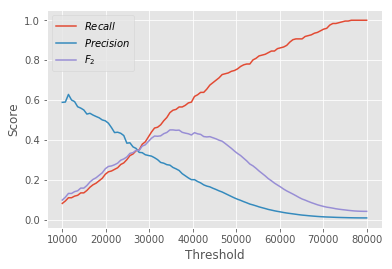

In [12]:
plt.plot(tresholds, scores[:, 0], label='$Recall$')
plt.plot(tresholds, scores[:, 1], label='$Precision$')
plt.plot(tresholds, scores[:, 2], label='$F_2$')
plt.ylabel('Score')
plt.xlabel('Threshold')
plt.legend(loc='best')
plt.show()

Final threshold: 35454
Test Recall Score: 0.492
Test Precision Score: 0.222
Test F2 Score: 0.396


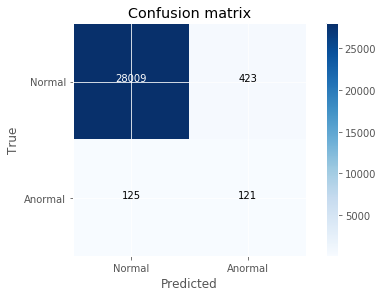

In [13]:
final_tresh = tresholds[scores[:, 2].argmax()]
y_hat_test = (model.predict(test.drop('Class', axis=1).values) < final_tresh).astype(int)

print('Final threshold: %d' % final_tresh)
print('Test Recall Score: %.3f' % recall_score(y_pred=y_hat_test, y_true=test['Class'].values))
print('Test Precision Score: %.3f' % precision_score(y_pred=y_hat_test, y_true=test['Class'].values))
print('Test F2 Score: %.3f' % fbeta_score(y_pred=y_hat_test, y_true=test['Class'].values, beta=2))

cnf_matrix = confusion_matrix(test['Class'].values, y_hat_test)
plot_confusion_matrix(cnf_matrix, classes=['Normal','Anormal'], title='Confusion matrix')

We can see that the performance of the model is not great. The $F_2$ score is only 0.49. Therefore, even with an approximate assumption of the histogram rendering the confusion matrix, we did not get the desired effect.

# Method 3: Cluster based technique

Next we try a cluster based technique. In this case we choose GaussianMixture which uses mixtures of different Gaussian distribution for clustering. The following code uses sklearn's Gaussian Mixture.

In [14]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=3, n_init=4, random_state=1)
gmm.fit(train.drop('Class', axis=1).values)
print(gmm.score(valid[valid['Class'] == 0].drop('Class', axis=1).values))
print(gmm.score(valid[valid['Class'] == 1].drop('Class', axis=1).values))

10.745761640679317
-253.26513398411328


Now, we classify.

In [15]:
tresholds = np.linspace(-400, 0, 100)
y_scores = gmm.score_samples(valid.drop('Class', axis=1).values)
scores = []
for treshold in tresholds:
    y_hat = (y_scores < treshold).astype(int)
    scores.append([recall_score(y_pred=y_hat, y_true=valid['Class'].values),
                 precision_score(y_pred=y_hat, y_true=valid['Class'].values),
                 fbeta_score(y_pred=y_hat, y_true=valid['Class'].values, beta=2)])

scores = np.array(scores)
print(scores[:, 2].max(), scores[:, 2].argmax())

0.7698476343223738 79


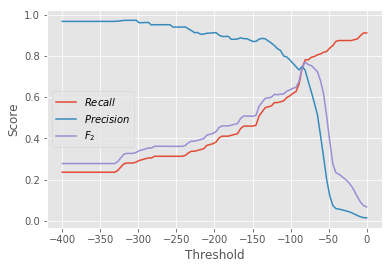

In [16]:
plt.plot(tresholds, scores[:, 0], label='$Recall$')
plt.plot(tresholds, scores[:, 1], label='$Precision$')
plt.plot(tresholds, scores[:, 2], label='$F_2$')
plt.ylabel('Score')
plt.xlabel('Threshold')
plt.legend(loc='best')
plt.show()

Finally, with the trained and tuned model, we produce a final evaluation on the test set.

Final threshold: -80.808081
Test Recall Score: 0.780
Test Precision Score: 0.658
Test F2 Score: 0.752


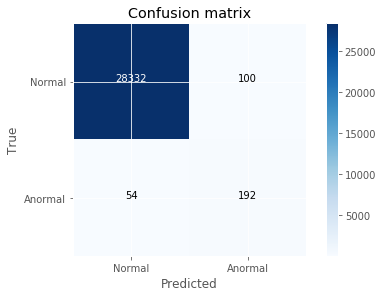

In [17]:
final_tresh = tresholds[scores[:, 2].argmax()]
y_hat_test = (gmm.score_samples(test.drop('Class', axis=1).values) < final_tresh).astype(int)

print('Final threshold: %f' % final_tresh)
print('Test Recall Score: %.3f' % recall_score(y_pred=y_hat_test, y_true=test['Class'].values))
print('Test Precision Score: %.3f' % precision_score(y_pred=y_hat_test, y_true=test['Class'].values))
print('Test F2 Score: %.3f' % fbeta_score(y_pred=y_hat_test, y_true=test['Class'].values, beta=2))

cnf_matrix = confusion_matrix(test['Class'].values, y_hat_test)
plot_confusion_matrix(cnf_matrix, classes=['Normal','Anormal'], title='Confusion matrix')

We got an $F_2$ score of 0.78. Also only 54 of Anormal entry is detected as normal entry here.

# Method 4: Support Vector Machines based techniques

Next we use SVM model. The SVM takes a very long time to complete compared to previous methods.

In [18]:
from sklearn.svm import OneClassSVM
np.random.seed(1)

model = OneClassSVM(gamma=0.000562, nu=.95, kernel='rbf')
model.fit(train.drop('Class', axis=1).values)

print(model.decision_function(valid[valid['Class'] == 0].drop('Class', axis=1).values).mean())
print(model.decision_function(valid[valid['Class'] == 1].drop('Class', axis=1).values).mean())

-2504.8684347342623
-57541.83570009607


We have to use the validation set to tune both the hyper-parameters of the one class SVM and the threshold. For the SVM, we used a radial basis kernel and tuned its hyper-parameters with a grid search.

In [19]:
tresholds = np.linspace(-50000, -400, 500)
y_scores = model.decision_function(valid.drop('Class', axis=1).values)
scores = []
for treshold in tresholds:
    y_hat = (y_scores < treshold).astype(int)
    scores.append([recall_score(y_pred=y_hat, y_true=valid['Class'].values),
                  precision_score(y_pred=y_hat, y_true=valid['Class'].values),
                 fbeta_score(y_pred=y_hat, y_true=valid['Class'].values, beta=2)])

scores = np.array(scores)
print(scores[:, 2].max(), scores[:, 2].argmax())

0.5490523968784838 376


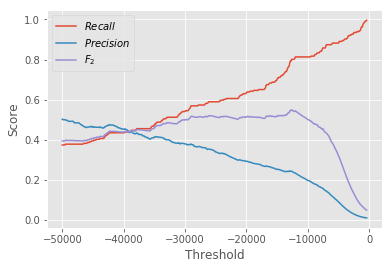

In [20]:
plt.plot(tresholds, scores[:, 0], label='$Recall$')
plt.plot(tresholds, scores[:, 1], label='$Precision$')
plt.plot(tresholds, scores[:, 2], label='$F_2$')
plt.ylabel('Score')
plt.xlabel('Threshold')
plt.legend(loc='best')
plt.show()

Finally, we report the results in the test set.

In [21]:
final_tresh = tresholds[scores[:, 2].argmax()]
y_hat_test = (model.decision_function(test.drop('Class', axis=1).values) < final_tresh).astype(int)

print('Final threshold: %f' % final_tresh)
print('Test Recall Score: %.3f' % recall_score(y_pred=y_hat_test, y_true=test['Class'].values))
print('Test Precision Score: %.3f' % precision_score(y_pred=y_hat_test, y_true=test['Class'].values))
print('Test F2 Score: %.3f' % fbeta_score(y_pred=y_hat_test, y_true=test['Class'].values, beta=2))

Final threshold: -12626.052104
Test Recall Score: 0.793
Test Precision Score: 0.219
Test F2 Score: 0.520


SVM is extremely slow, but does not have better F2 only 0.520.

# Method 5: Tree based techniques

Next we apply Isolation Forest tree from sklearn. This create many random forest trees and randomly selects a feature.

In [22]:
from sklearn.ensemble import IsolationForest

np.random.seed(1)

model = IsolationForest(random_state=42, n_jobs=4, max_samples=train.shape[0], bootstrap=True, n_estimators=50)
model.fit(train.drop('Class', axis=1).values)
print(model.decision_function(valid[valid['Class'] == 0].drop('Class', axis=1).values).mean())
print(model.decision_function(valid[valid['Class'] == 1].drop('Class', axis=1).values).mean())

/Users/fda/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:214: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/fda/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:224: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)


0.15740140543134826
-0.03308070398021559


Using our validation set, we tune a threshold for our score.

In [23]:
tresholds = np.linspace(-.2, .2, 200)
y_scores = model.decision_function(valid.drop('Class', axis=1).values)
scores = []
for treshold in tresholds:
    y_hat = (y_scores < treshold).astype(int)
    scores.append([recall_score(y_pred=y_hat, y_true=valid['Class'].values),
                 precision_score(y_pred=y_hat, y_true=valid['Class'].values),
                 fbeta_score(y_pred=y_hat, y_true=valid['Class'].values, beta=2)])

scores = np.array(scores)
print(scores[:, 2].max(), scores[:, 2].argmax())

0.656140350877193 139


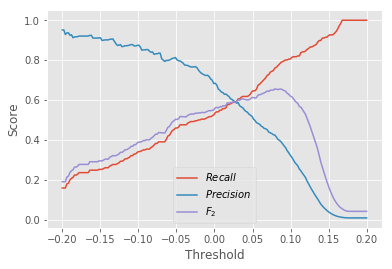

In [24]:
plt.plot(tresholds, scores[:, 0], label='$Recall$')
plt.plot(tresholds, scores[:, 1], label='$Precision$')
plt.plot(tresholds, scores[:, 2], label='$F_2$')
plt.ylabel('Score')
plt.xlabel('Threshold')
plt.legend(loc='best')
plt.show()

Using the optimal threshold, we report a final test score.

Final threshold: 0.079397
Test Recall Score: 0.780
Test Precision Score: 0.394
Test F2 Score: 0.653


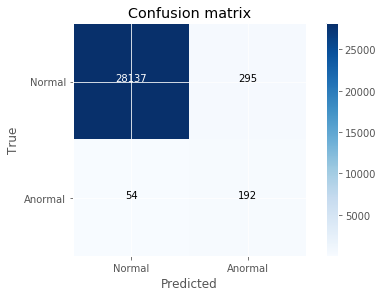

In [25]:
final_tresh = tresholds[scores[:, 2].argmax()]
y_hat_test = (model.decision_function(test.drop('Class', axis=1).values) < final_tresh).astype(int)

print('Final threshold: %f' % final_tresh)
print('Test Recall Score: %.3f' % recall_score(y_pred=y_hat_test, y_true=test['Class'].values))
print('Test Precision Score: %.3f' % precision_score(y_pred=y_hat_test, y_true=test['Class'].values))
print('Test F2 Score: %.3f' % fbeta_score(y_pred=y_hat_test, y_true=test['Class'].values, beta=2))

cnf_matrix = confusion_matrix(test['Class'].values, y_hat_test)
plot_confusion_matrix(cnf_matrix, classes=['Normal','Anormal'], title='Confusion matrix')

# Conclusion
In this post, I presented several techniques to determine anomaly in a large dataset. 